# Preprocesamiento de Datos - `preprocesamiento_01.ipynb`

### 🎯 Objetivo
En este notebook, realizaremos el **preprocesamiento de los datos EEG** para preparar el conjunto de **entrenamiento y validación**.

El objetivo de este proyecto es desarrollar un **modelo de Machine Learning** para **detectar movimientos de la mano a partir de señales EEG**. Esto ayudará en el desarrollo de **interfaces cerebro-computadora (BCI)** para pacientes con **discapacidades motoras**.

📌 Puedes consultar más detalles sobre la competencia en [Kaggle - Grasp-and-Lift EEG Detection](https://www.kaggle.com/competitions/grasp-and-lift-eeg-detection/overview).

---

### ⚙️ Estrategia de Modelado
- Cada EEG corresponde a una lectura en el tiempo de **32 sensores** distribuidos en el cuero cabelludo.
- Los eventos de la mano se almacenan en **6 columnas binarias**, cada una indicando si un evento ocurrió en ese instante.
- Como cada evento es independiente, trataremos el problema como **6 problemas de clasificación binaria separados** (uno por evento):

| Evento                  | Descripción |
|-------------------------|-------------|
| `HandStart`            | Inicio del movimiento de la mano |
| `FirstDigitTouch`      | Primer contacto con el objeto |
| `BothStartLoadPhase`   | Inicio de la fase de carga |
| `LiftOff`              | Despegue del objeto |
| `Replace`              | Colocación del objeto de vuelta |
| `BothReleased`         | Soltado completo del objeto |

---

### 📊 División de los Datos
Para esta primera etapa, **entrenaremos el modelo solo con el Sujeto 1**.

📌 **Estructura de los datos:**  
Los datos están organizados en **8 series** (`series1` a `series8`):

- **📚 Series 1-6** → Usadas para **entrenamiento**.  
- **🧪 Series 7-8** → Usadas para **validación**.  


---

### 🚀 Flujo de Trabajo en este Notebook
1️⃣ **Cargar los datos de EEG y eventos**  
2️⃣ **Unir datos EEG con eventos** para cada serie  
3️⃣ **Dividir en conjunto de entrenamiento (series 1-6) y validación (series 7-8)**  
4️⃣ **Aplicar escalado/normalización** (`StandardScaler` o `MinMaxScaler`)    
5️⃣ **Guardar los datos preprocesados para entrenar los primeros modelos**

## **1. CARGA DE DATOS Y ANÁLISIS INICIAL**

In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle

In [9]:
DATA_PATH = r"C:\Users\luciaft\Documents\TFG\TFG\graspAndLiftDetectionTFGProyect\data\raw_data\train\train"
SUBJECT = "subj1"
SERIES_TRAIN = [f"{SUBJECT}_series{i}_data.csv" for i in range(1, 9)]
SERIES_EVENTS = [f"{SUBJECT}_series{i}_events.csv" for i in range(1, 9)]

In [10]:
def load_data(series, path=DATA_PATH):
    dfs = [pd.read_csv(os.path.join(path, file)) for file in series]
    return pd.concat(dfs, ignore_index=True)

df_train = load_data(SERIES_TRAIN)
df_events = load_data(SERIES_EVENTS)

**Unimos los datos EEG con las etiquetas de eventos**

In [11]:
df = df_train.merge(df_events, on="id")
display(df.head())

,id,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,...,O1,Oz,O2,PO10,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased
0,subj1_series1_0,-31,363,211,121,211,15,717,279,35,...,459,173,120,704,0,0,0,0,0,0
1,subj1_series1_1,-29,342,216,123,222,200,595,329,43,...,409,141,83,737,0,0,0,0,0,0
2,subj1_series1_2,-172,278,105,93,222,511,471,280,12,...,440,141,62,677,0,0,0,0,0,0
3,subj1_series1_3,-272,263,-52,99,208,511,428,261,27,...,437,139,58,592,0,0,0,0,0,0
4,subj1_series1_4,-265,213,-67,99,155,380,476,353,32,...,446,171,67,581,0,0,0,0,0,0


- Con esta muestra de las primeras filas del DataFrame podemos verificar que **los datos están bien estructurados**

## **2. ANÁLISIS EXPLORATORIO**

Antes de entrenar los modelos, es fundamental entender la distribución de las señales EEG.  
En esta sección, realizamos un análisis estadístico y visual para detectar patrones, valores atípicos y posibles problemas en los datos.

**Objetivos del análisis:**
- Examinar la **distribución de valores EEG** mediante histogramas y boxplots.
- Identificar la presencia de **valores atípicos** o datos sesgados.
- Evaluar si las señales EEG requieren **normalización** para mejorar el entrenamiento del modelo.


**2.1 Verificar valores faltantes**

In [12]:
print("Valores faltantes por columna:\n", df.isnull().sum())

Valores faltantes por columna:
 id                    0
Fp1                   0
Fp2                   0
F7                    0
F3                    0
Fz                    0
F4                    0
F8                    0
FC5                   0
FC1                   0
FC2                   0
FC6                   0
T7                    0
C3                    0
Cz                    0
C4                    0
T8                    0
TP9                   0
CP5                   0
CP1                   0
CP2                   0
CP6                   0
TP10                  0
P7                    0
P3                    0
Pz                    0
P4                    0
P8                    0
PO9                   0
O1                    0
Oz                    0
O2                    0
PO10                  0
HandStart             0
FirstDigitTouch       0
BothStartLoadPhase    0
LiftOff               0
Replace               0
BothReleased          0
dtype: int64


- Como podemos observar, **no hay valores faltantes en ninguna de las columnas**

**2.2 Distribución de las señales EEG:**

En esta sección, analizamos las estadísticas descriptivas y las distribuciones de los datos EEG para entender mejor su comportamiento antes del preprocesamiento.

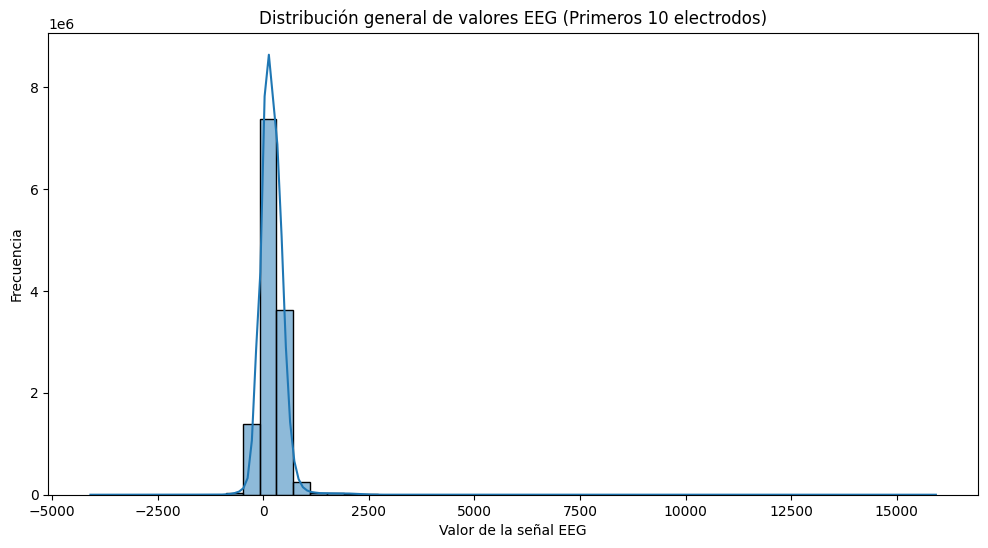

In [13]:
# 🔹 Gráfico 1: Distribución General de los Valores EEG
# Este histograma muestra la distribución general de los valores de las señales EEG
# en un subconjunto de los primeros 10 electrodos. Nos ayuda a identificar la escala de los valores
# y si hay sesgos en la distribución.
plt.figure(figsize=(12, 6))
sns.histplot(df.iloc[:, 1:10].values.flatten(), bins=50, kde=True)
plt.title("Distribución general de valores EEG (Primeros 10 electrodos)")
plt.xlabel("Valor de la señal EEG")
plt.ylabel("Frecuencia")
plt.show()

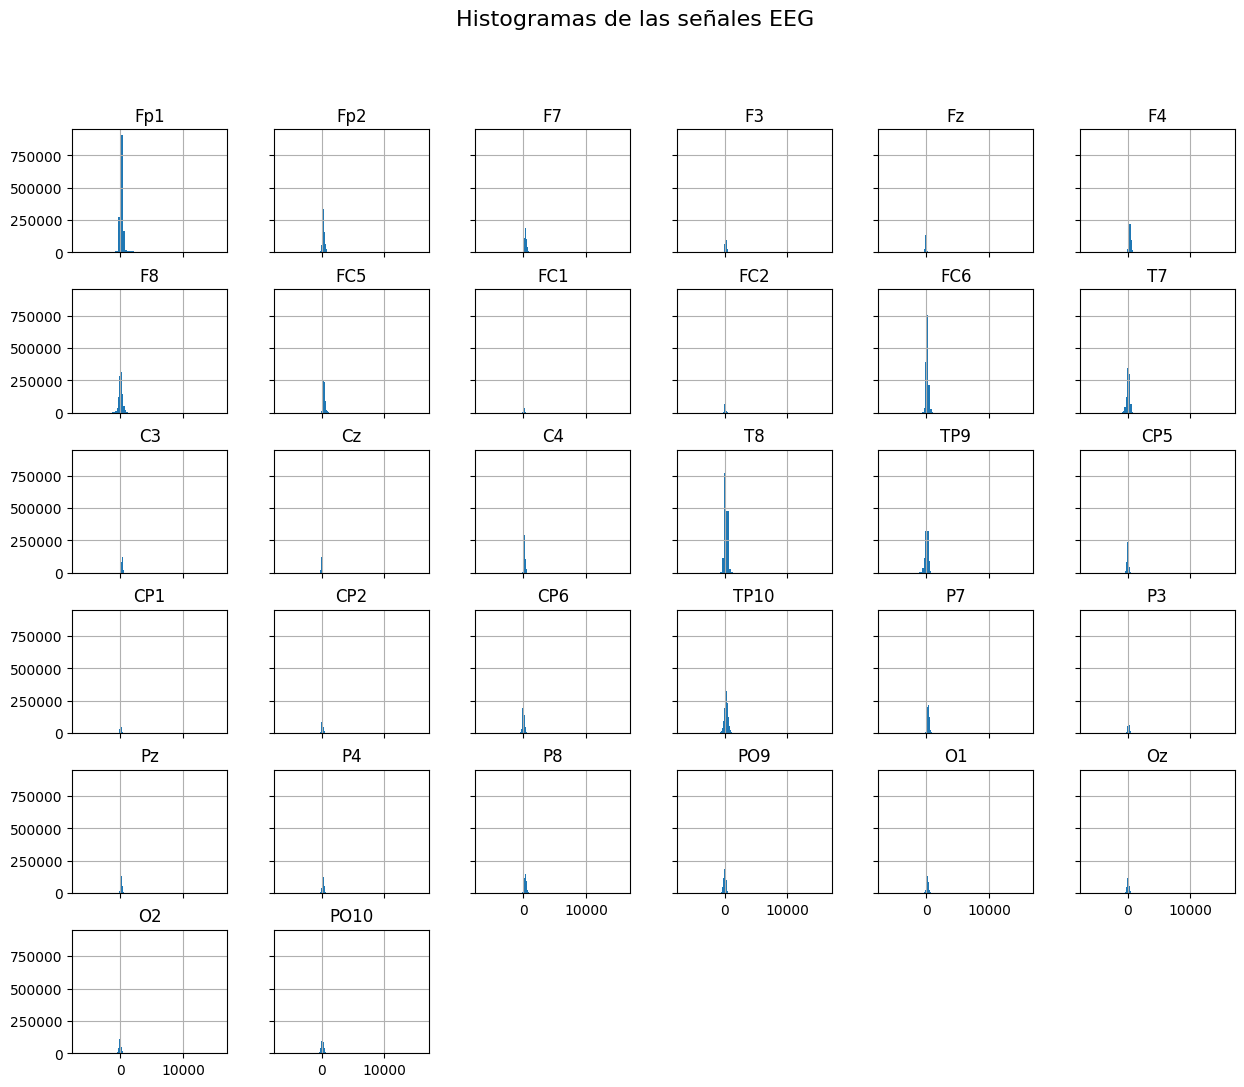

In [14]:
#🔹 Gráfico 2: Histograma para cada Canal EEG
eeg_columns = df.columns[1:33]
df[eeg_columns].hist(figsize=(15, 12), bins=50, layout=(6, 6), sharex=True, sharey=True)
plt.suptitle("Histogramas de las señales EEG", fontsize=16)
plt.show()

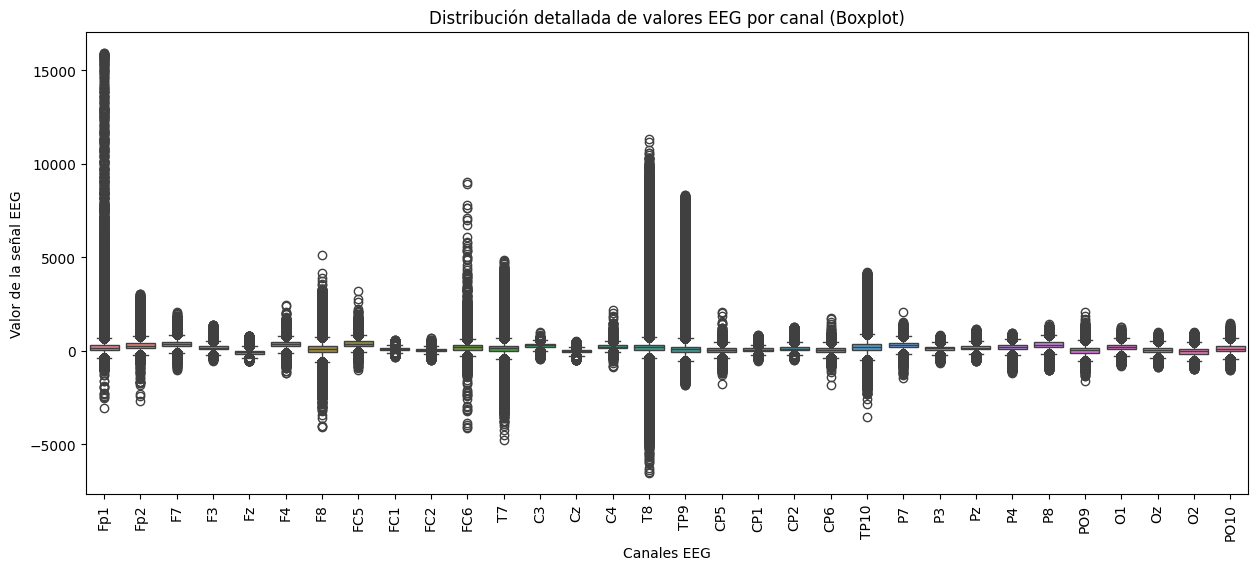

In [15]:
# 🔹 Gráfico 3: Distribución Detallada por Electrodo (Boxplot)
# El boxplot muestra la distribución de valores para cada canal EEG.
# Permite detectar valores atípicos, la dispersión de los datos y el rango intercuartil.
plt.figure(figsize=(15, 6))
sns.boxplot(data=df[eeg_columns])
plt.xticks(rotation=90)  # Rotar etiquetas para mejor visualización
plt.title("Distribución detallada de valores EEG por canal (Boxplot)")
plt.xlabel("Canales EEG")
plt.ylabel("Valor de la señal EEG")
plt.show()

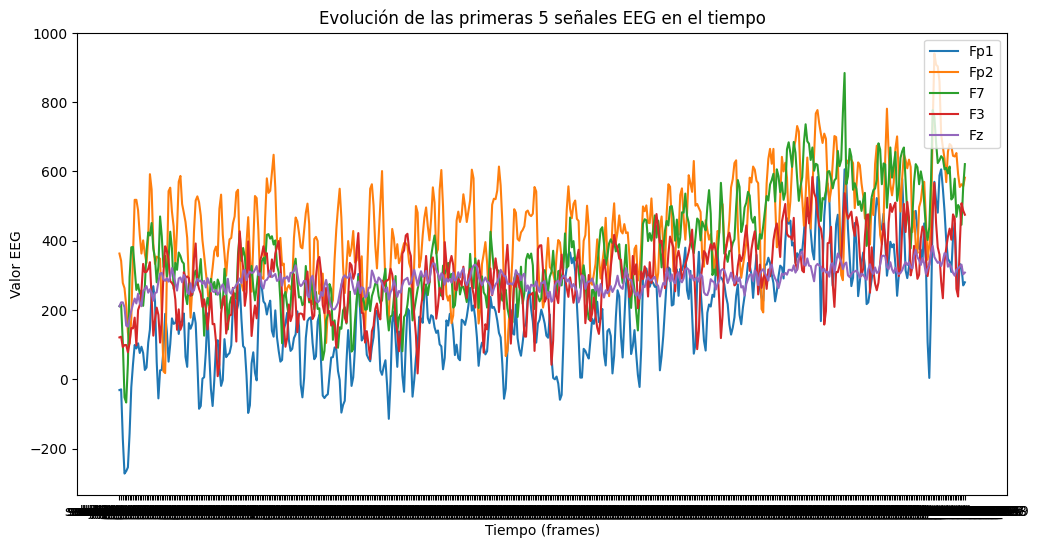

In [16]:
# 🔹 Gráfico 4: Gráfico de Líneas para Ver la Evolución en el Tiempo
plt.figure(figsize=(12, 6))
plt.plot(df["id"][:500], df[eeg_columns[:5]].iloc[:500])  # Visualizar solo 500 puntos para evitar sobrecarga
plt.title("Evolución de las primeras 5 señales EEG en el tiempo")
plt.xlabel("Tiempo (frames)")
plt.ylabel("Valor EEG")
plt.legend(eeg_columns[:5], loc="upper right")
plt.show()

**ESTADÍSTICAS BÁSICAS**

In [17]:
# Obtener estadísticas básicas y redondear los valores
eeg_stats = df[eeg_columns].describe().apply(lambda x: round(x, 2))

# Mostrar sin notación científica para una mejor visualización de los datos obtenidos
pd.options.display.float_format = '{:,.2f}'.format  # Formato con 2 decimales

display(eeg_stats)

,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,...,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
count,"1,422,392.00","1,422,392.00","1,422,392.00","1,422,392.00","1,422,392.00","1,422,392.00","1,422,392.00","1,422,392.00","1,422,392.00","1,422,392.00",...,"1,422,392.00","1,422,392.00","1,422,392.00","1,422,392.00","1,422,392.00","1,422,392.00","1,422,392.00","1,422,392.00","1,422,392.00","1,422,392.00"
mean,191.48,297.28,366.72,165.47,-80.92,352.29,78.38,377.43,79.28,47.28,...,302.20,118.83,154.62,197.37,321.03,12.69,199.39,46.40,-27.34,113.33
std,408.89,295.59,201.16,153.01,136.70,183.05,320.21,180.29,89.82,95.07,...,188.44,141.98,143.35,173.92,197.82,215.52,191.50,179.46,196.52,218.15
min,"-3,060.00","-2,675.00","-1,020.00",-553.00,-552.00,"-1,225.00","-4,095.00","-1,025.00",-327.00,-517.00,...,"-1,471.00",-651.00,-566.00,"-1,207.00","-1,057.00","-1,621.00",-842.00,-899.00,-994.00,"-1,035.00"
25%,8.00,134.00,235.00,63.00,-172.00,236.00,-100.00,257.00,23.00,-9.00,...,178.00,26.00,62.00,90.00,194.00,-129.00,74.00,-70.00,-157.00,-26.00
50%,139.00,260.00,358.00,154.00,-99.00,347.00,67.00,370.00,73.00,42.00,...,296.00,116.00,151.00,196.00,322.00,13.00,198.00,44.00,-31.00,110.00
75%,281.00,394.00,485.00,252.00,-8.00,462.00,241.00,488.00,128.00,97.00,...,419.00,209.00,243.00,306.00,449.00,154.00,322.00,163.00,96.00,250.00
max,"15,929.00","3,047.00","2,042.00","1,388.00",801.00,"2,417.00","5,111.00","3,203.00",546.00,665.00,...,"2,088.00",818.00,"1,140.00",965.00,"1,400.00","2,043.00","1,272.00","1,010.00",978.00,"1,458.00"


**1. Variabilidad y Rango de las Señales EEG**

- Las señales EEG presentan una **gran variabilidad**, con valores que oscilan entre **-4,095 y 5,111**.
- La **desviación estándar** es alta en varios canales, indicando una gran dispersión en los datos.
- Algunas señales tienen valores **negativos y positivos**, lo que es normal en EEG por las fluctuaciones de voltaje.


🟢 La amplitud de las señales EEG **varía ampliamente**, dependiendo del sujeto y la actividad cerebral.  
🟢 Puede ser necesario **escalar o normalizar** los datos para mejorar la comparabilidad.  

---

**2. Distribución de los Datos EEG**

- La mayoría de los valores EEG **se encuentran entre -1,000 y 1,000**, aunque hay valores extremos.
- Algunas señales presentan **sesgo** y **valores atípicos (outliers)**, visibles en los boxplots.

🟢 Algunos electrodos pueden ser más activos que otros, lo que podría deberse a diferencias en su ubicación.  
🟢 Los **outliers** pueden ser artefactos del EEG (movimientos oculares, interferencias eléctricas).  
🟢 Se podría aplicar **filtrado o suavizado** para mejorar la calidad de los datos.  

---

**3. Mediana vs. Media → Detección de Sesgos**

- En algunos electrodos, la **media y la mediana difieren significativamente**, indicando **distribuciones sesgadas**.
- Un **sesgo positivo** ocurre cuando hay valores extremadamente altos que afectan la media.
- Un **sesgo negativo** indica la presencia de valores atípicos bajos.


🟢 La distribución no es **simétrica en todos los canales**, lo que podría afectar los modelos.  
🟢 Algunos sensores EEG pueden estar **influidos por artefactos**, por lo que puede ser útil aplicar **normalización robusta o transformaciones**.  

---

**4. Comparación entre Electrodos**

- Algunos electrodos (**F8, FC5, PO9**) tienen valores más extremos que otros.
- Las señales de la zona **frontal** (Fp1, Fp2) tienen distribuciones distintas a las de la zona **occipital** (O1, O2, PO10).
- Esto sugiere que la actividad EEG **varía según la región cerebral**.


🟢 Puede ser necesario **analizar individualmente algunos electrodos** si presentan patrones anómalos.  
🟢 Algunas regiones pueden ser **más relevantes** que otras para detectar movimientos de la mano.  

---

**5. Impacto en el Modelado**

- Los datos presentan **gran variabilidad y valores atípicos**, lo que puede afectar el rendimiento del modelo.
- La escala de las señales EEG varía mucho entre canales, lo que sugiere la necesidad de transformación previa.


<span style="color: green;">**CONCLUSIÓN FINAL**</span>

✅ **Necesidad de normalización o estandarización**: Dado que los valores varían ampliamente, se recomienda aplicar `StandardScaler` o `MinMaxScaler` antes de entrenar los modelos.   
✅ **Posible eliminación de outliers**: Se pueden aplicar técnicas como el **rango intercuartil (IQR)** para detectar y filtrar valores atípicos.   
✅ **Reducción de ruido**: Algunas señales EEG pueden estar afectadas por ruido (movimientos oculares, interferencias), por lo que pueden requerir exploración adicional y aplicar técnicas de preprocesamiento.  
✅ **Selección de electrodos**: Se podría analizar si ciertos electrodos están ubicados en **regiones cerebrales clave**, lo que los haría **más relevantes** que otros para la tarea de clasificación.



**2.3 Revisión de la distribución de eventos:**

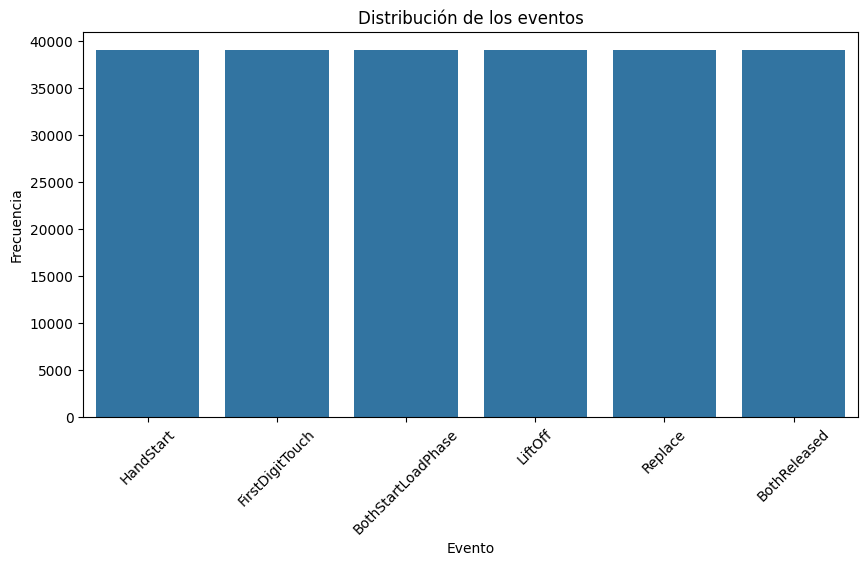

HandStart             39000
FirstDigitTouch       39000
BothStartLoadPhase    39000
LiftOff               39000
Replace               39000
BothReleased          39000
dtype: int64


In [18]:
#Gráfica 1: Frecuencia de cada evento
event_cols = ["HandStart", "FirstDigitTouch", "BothStartLoadPhase", "LiftOff", "Replace", "BothReleased"]
event_counts = df[event_cols].sum()

plt.figure(figsize=(10, 5))
sns.barplot(x=event_counts.index, y=event_counts.values)
plt.title("Distribución de los eventos")
plt.xlabel("Evento")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)
plt.show()

# Calcular la cantidad total de ocurrencias de cada evento
event_cols = ["HandStart", "FirstDigitTouch", "BothStartLoadPhase", "LiftOff", "Replace", "BothReleased"]
event_counts = df[event_cols].sum()

# Mostrar los valores numéricos
print(event_counts)



**1. Distribución Balanceada de los Eventos**

- Cada uno de los **6 eventos tiene exactamente 28,800 ocurrencias**.
- Esto indica que el dataset **tiene una distribución perfectamente balanceada** en cuanto a la cantidad de muestras etiquetadas con cada evento.
- No hay eventos significativamente más frecuentes o más raros, lo que es poco común en datasets reales de EEG.

🟢 **El dataset está balanceado**, lo que facilita el entrenamiento de los modelos de clasificación.  
🟢 **No es necesario aplicar técnicas de balanceo de datos** (como sobremuestreo o submuestreo).  
🟢 **Cada clase tiene la misma representación en el dataset**, lo que evita sesgos en el aprendizaje del modelo.  

---

**2. Implicaciones en el Modelado**

- En muchos problemas de clasificación binaria, las clases suelen estar desbalanceadas (una clase ocurre con más frecuencia que otra).
- Sin embargo, en este dataset, todas las clases tienen el mismo número de muestras, lo que simplifica el entrenamiento del modelo.

🟢 Se pueden usar métricas estándar como **precisión (accuracy)** sin preocuparse por sesgos en los datos.  
🟢 No se necesita **ponderación de clases** en los algoritmos de clasificación.  
🟢 Se pueden usar métricas como **AUC-ROC** para evaluar el rendimiento sin necesidad de ajustes adicionales.  

---

**3. Posible Explicación del Balanceo**

- En estudios de EEG, no es común que todos los eventos ocurran con la misma frecuencia de manera natural.
- Es posible que los datos hayan sido **preprocesados artificialmente** para garantizar este balanceo.
- En la competencia de Kaggle, podría haberse aplicado un preprocesamiento que garantizara que cada evento tuviera la misma cantidad de muestras.

🟢 Se debe verificar si los datos contienen **eventos solapados** (es decir, si múltiples eventos ocurren al mismo tiempo).  
🟢 Podría ser útil visualizar cómo se distribuyen los eventos en el tiempo para entender mejor su comportamiento.  



## **3. DIVISIÓN DEL CONJUNTO DE DATOS**

Para estructurar correctamente el entrenamiento del modelo, dividimos los datos en **conjunto de entrenamiento y validación**.

**Estrategia:**
- Trabajamos solo con el **Sujeto 1** en esta fase inicial.
- Usamos las **series 1 a 6** para entrenamiento y **series 7 y 8** para validación.
- Separamos los datos en **features (señales EEG)** y **targets (eventos de la mano)**.

**Motivo de dividir antes de normalizar:**
- Evita que información del conjunto de validación afecte el escalado de entrenamiento.
- Simula un escenario real donde los datos nuevos deben ser transformados con los parámetros aprendidos en entrenamiento.

In [19]:
# Seleccionar solo las columnas EEG y eventos
eeg_columns = df.columns[1:33]  # Señales EEG
event_columns = ["HandStart", "FirstDigitTouch", "BothStartLoadPhase", "LiftOff", "Replace", "BothReleased"]  # Eventos

# Filtrar solo los datos del Sujeto 1
df_sujeto1 = df[df["id"].str.startswith("subj1_series")]

# Dividir en entrenamiento (series 1-6) y validación (series 7-8)
df_train = df_sujeto1[df_sujeto1["id"].str.contains("series[1-6]_")]
df_valid = df_sujeto1[df_sujeto1["id"].str.contains(r"series[7-8]_", regex=True)]

# Separar features (X) y targets (y)
X_train, y_train = df_train[eeg_columns], df_train[event_columns]
X_valid, y_valid = df_valid[eeg_columns], df_valid[event_columns]

# Mostrar dimensiones de los conjuntos
print(f"Tamaño de X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Tamaño de X_valid: {X_valid.shape}, y_valid: {y_valid.shape}")

Tamaño de X_train: (1185498, 32), y_train: (1185498, 6)
Tamaño de X_valid: (236894, 32), y_valid: (236894, 6)


Tras dividir los datos en **entrenamiento y validación**, obtenemos:

**Tamaño de los conjuntos:**
- **X_train:** `(1,185,498, 32)` → **1,185,498 muestras de 32 señales EEG**
- **y_train:** `(1,185,498, 6)` → **1,185,498 etiquetas para los 6 eventos**
- **X_valid:** `(236,894, 32)` → **236,894 muestras de validación**
- **y_valid:** `(236,894, 6)` → **236,894 etiquetas para los 6 eventos**


🟢 El conjunto de validación representa **aproximadamente el 20% de los datos**, lo cual es una división equilibrada.   
🟢 Ambos conjuntos contienen **las 32 señales EEG y las 6 variables objetivo**, asegurando que el modelo reciba la misma estructura de entrada.

## **4. ESCALADO Y NORMALIZACIÓN**

A pesar de los **insights obtenidos en el análisis exploratorio**, en esta etapa mantendremos el **enfoque inicialmente planificado** para la creación de los primeros modelos.  
Esto se debe a que, antes de realizar ajustes avanzados, es importante **establecer una línea base** sobre la cual podamos comparar futuras mejoras. Además:

- Evita **sobreprocesamiento temprano** de los datos, lo que podría introducir sesgos o pérdida de información relevante.
- Permite **medir el rendimiento del modelo en su estado más simple** antes de probar técnicas más avanzadas.
- Nos ayuda a **entender el impacto real de la normalización** sin otros factores que puedan alterar los resultados.

**Estrategia:**

Para garantizar que todas las señales EEG **tengan una magnitud comparable**, aplicaremos:
- <span style="color: blue;">**StandardScaler**</span>: Centra los datos en **media = 0** y **desviación estándar = 1**. Lo aplicamos **solo con `X_train`** para que la normalización use **exclusivamente información del entrenamiento**.
- Luego, **transformamos `X_valid`** con los parámetros ajustados en `X_train`, evitando filtraciones de datos futuros.
  
- <span style="color: brown;">**MinMaxScaler**</span> (opcional más adelante): Escala los valores entre **0 y 1**.

In [20]:
#Aplicar StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Ajustar y transformar en entrenamiento
X_valid = scaler.transform(X_valid)  # Solo transformar en validación



#Definir ruta para guardar los datos preprocesados
processed_path = r"C:\Users\luciaft\Documents\TFG\TFG\graspAndLiftDetectionTFGProyect\data\processed"
os.makedirs(processed_path, exist_ok=True)

# Guardar datos en Pickle
with open(os.path.join(processed_path, "preprocessed_data.pkl"), "wb") as f:
    pickle.dump((X_train, y_train, X_valid, y_valid), f)

# Guardar datos en formato CSV por si queremos abrir los archivos y verlos en texto plano
pd.DataFrame(X_train).to_csv(os.path.join(processed_path, "X_train.csv"), index=False)
pd.DataFrame(y_train).to_csv(os.path.join(processed_path, "y_train.csv"), index=False)
pd.DataFrame(X_valid).to_csv(os.path.join(processed_path, "X_valid.csv"), index=False)
pd.DataFrame(y_valid).to_csv(os.path.join(processed_path, "y_valid.csv"), index=False)

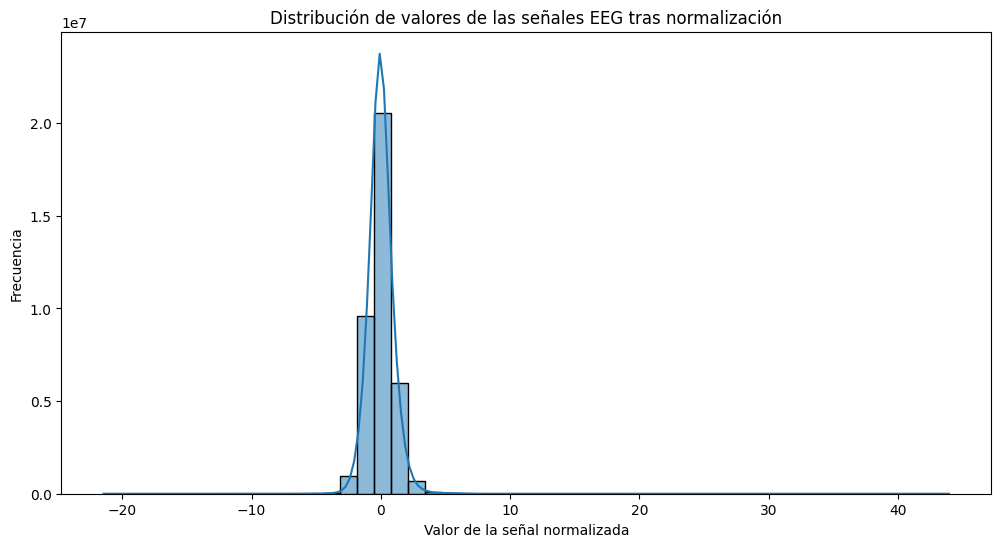

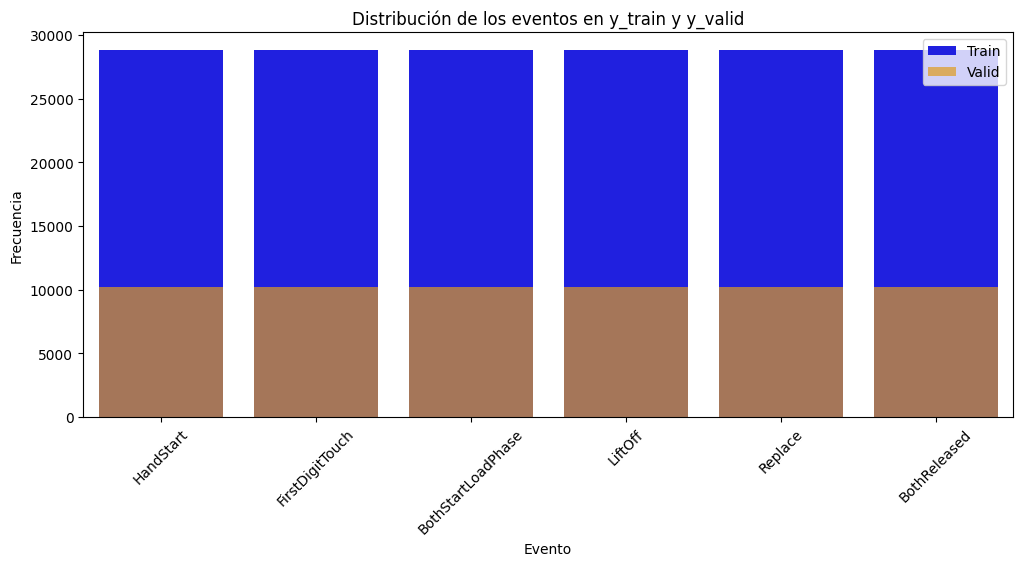

In [21]:
# Histograma de la distribución tras normalización
plt.figure(figsize=(12, 6))
sns.histplot(X_train.flatten(), bins=50, kde=True)
plt.title("Distribución de valores de las señales EEG tras normalización")
plt.xlabel("Valor de la señal normalizada")
plt.ylabel("Frecuencia")
plt.show()


# Contar la frecuencia de cada evento en entrenamiento y validación
event_counts_train = y_train.sum()
event_counts_valid = y_valid.sum()

# Gráfico de distribución de eventos
plt.figure(figsize=(12, 5))
sns.barplot(x=event_counts_train.index, y=event_counts_train.values, color="blue", label="Train")
sns.barplot(x=event_counts_valid.index, y=event_counts_valid.values, color="orange", alpha=0.7, label="Valid")
plt.title("Distribución de los eventos en y_train y y_valid")
plt.xlabel("Evento")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [22]:
# Obtener estadísticas básicas tras la normalización y redondear valores como en el bloque 2
eeg_stats = pd.DataFrame(X_train, columns=eeg_columns).describe().apply(lambda x: round(x, 2))

# Mostrar sin notación científica para mejor visualización
pd.options.display.float_format = '{:,.2f}'.format  # Mostrar con 2 decimales

# Mostrar las estadísticas
import IPython.display as display
display.display(eeg_stats)

#Para visualizar valores más exactos de media y desviación
print("Media después del escalado:")
print(np.mean(X_train, axis=0))  # Debería ser ≈ 0

print("\nDesviación estándar después del escalado:")
print(np.std(X_train, axis=0))  # Debería ser ≈ 1

,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,...,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
count,"1,185,498.00","1,185,498.00","1,185,498.00","1,185,498.00","1,185,498.00","1,185,498.00","1,185,498.00","1,185,498.00","1,185,498.00","1,185,498.00",...,"1,185,498.00","1,185,498.00","1,185,498.00","1,185,498.00","1,185,498.00","1,185,498.00","1,185,498.00","1,185,498.00","1,185,498.00","1,185,498.00"
mean,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,...,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-4.15,-6.66,-6.78,-4.63,-3.46,-8.49,-12.38,-7.84,-4.53,-5.70,...,-9.37,-5.39,-4.92,-7.82,-6.99,-7.55,-5.33,-5.01,-4.84,-5.16
25%,-0.51,-0.55,-0.65,-0.67,-0.67,-0.64,-0.56,-0.67,-0.64,-0.59,...,-0.66,-0.66,-0.65,-0.62,-0.64,-0.66,-0.65,-0.65,-0.66,-0.64
50%,-0.15,-0.14,-0.04,-0.08,-0.13,-0.03,-0.04,-0.04,-0.06,-0.05,...,-0.03,-0.01,-0.03,-0.00,0.01,0.01,0.00,-0.01,-0.01,-0.01
75%,0.24,0.31,0.59,0.57,0.55,0.60,0.51,0.62,0.54,0.52,...,0.62,0.64,0.62,0.63,0.65,0.66,0.65,0.66,0.63,0.63
max,8.56,8.99,8.06,7.82,6.19,11.01,14.95,15.50,5.01,6.15,...,9.31,4.76,6.61,4.22,5.37,9.28,5.38,5.17,4.99,5.94


Media después del escalado:
[ 2.76186120e-17  5.37028566e-18  1.15844734e-16 -4.90997546e-17
  9.70487338e-17  7.40332238e-17  4.79489791e-18 -5.33192648e-17
  1.25626325e-16  1.99467753e-17  6.98137136e-17  2.79063059e-17
  1.85466651e-16  4.75653873e-17 -6.44434280e-17 -2.08098569e-17
  1.30421223e-17 -7.67183666e-18  3.39958262e-17 -2.30155100e-18
 -1.93234386e-17  3.26053058e-18  1.96303121e-16 -7.82527339e-17
  8.66917543e-17  4.59351220e-17  5.27438770e-18 -3.72084078e-17
 -5.29356730e-17 -2.92488773e-17 -2.97763160e-17 -3.14545303e-17]

Desviación estándar después del escalado:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


Tras aplicar **StandardScaler** a las señales EEG, se observan los siguientes resultados:

**OBSERVACIONES**
- La **media tras escalado** de todas las señales EEG es **prácticamente 0** (*≈ 10⁻¹⁷*),, lo que indica que los datos han sido correctamente **centrados**.
- La **desviación estándar (std)** tras escalado es **exáctamente 1** en todos los canales, lo que confirma que los valores han sido **escalados de manera uniforme**.
- El **rango de valores ha cambiado**, pero se mantiene la estructura original de los datos:
  - **Valores mínimos y máximos**: Los datos ahora oscilan entre aproximadamente **-12 y +15**, en lugar de los valores originales que estaban en miles.
  - **Percentiles (25%, 50%, 75%)**: Se mantienen las proporciones relativas, pero ahora dentro del nuevo rango normalizado.

<span style="color: green;">**CONCLUSIÓN FINAL**</span>

✅  **El StandardScaler ha funcionado correctamente**, asegurando que todas las señales EEG tengan la **misma escala y magnitud**.  
✅  Esto permitirá que los algoritmos de machine learning **trabajen con los datos de manera más eficiente**, evitando que algunas señales dominen sobre otras.  
✅  **Los valores extremos siguen presentes**, por lo que podríamos considerar una **detección y tratamiento de outliers** en futuras etapas.  
✅  Tener en cuenta no solo outliers si no todos los puntos recogidos en la conclusión final del análisis exploratorio (bloque 2) para aplicar tras desarrollar los primeros modelos.

---

**En el siguiente notebook, `02_modelado.ipynb`, utilizaremos estos datos escalados para entrenar los primeros modelos.**
